In [3]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sys
# import sweetviz as sv
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
import timeshap as ts
from timeshap import __version__
__version__

np.warnings = warnings

ROOT_DIR = Path('../..')
sys.path.append(os.path.abspath(os.path.join('../src')))
sys.path.append(os.path.abspath(os.path.join('..')))
import src.DataLoader as DataLoader
reload(DataLoader)

dataLoader = DataLoader.DataLoader(ROOT_DIR)

import src.model_evaluation as me
reload(me)

<module 'src.model_evaluation' from '/home/labadmin/work/data-science-capstone-project/Kha Huynh/src/model_evaluation.py'>

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectFromModel

# model comparison
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
# from xgboost import XGBClassifier

# evaluation metrics
from sklearn.metrics import cohen_kappa_score,classification_report
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, auc, make_scorer
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, balanced_accuracy_score
from sklearn.metrics import PrecisionRecallDisplay
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import balanced_accuracy_score

import tensorflow as tf

2023-10-21 23:56:42.070122: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-21 23:56:42.071341: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-21 23:56:42.096076: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-21 23:56:42.096856: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-21 23:56:42.548862: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

# Data Preparation

In [ ]:
# t0_df = pd.read_csv(df_final)
path_df = ROOT_DIR / 'data/full_data_lstm/t8_top20_sequence.csv'
df_data = pd.read_csv(path_df)# t0_df
max_rows = df_data.groupby(['SUBJECT_ID', 'HADM_ID']).size().max()

admission = df_data[['SUBJECT_ID', 'HADM_ID', 'IS_SEPSIS']].drop_duplicates(["SUBJECT_ID", "HADM_ID"])

x_train_df, x_test_df, _, _ = train_test_split(
    admission.drop('IS_SEPSIS', axis=1),  # dropping the target column for X values
    admission['IS_SEPSIS'],
    test_size=0.2,  # this means 20% test set
    stratify=admission['IS_SEPSIS'],  # stratify by the target variable
    random_state=42  # to ensure reproducibility
)
x_train_df = df_data.merge(x_train_df[['SUBJECT_ID', 'HADM_ID']])
x_train_df['count'] = x_train_df.groupby(['SUBJECT_ID', 'HADM_ID'])['HADM_ID'].transform('count')
x_train_count = x_train_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['count']
y_train_df = x_train_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['IS_SEPSIS']

x_test_df = df_data.merge(x_test_df[['SUBJECT_ID', 'HADM_ID']])
x_test_df['count'] = x_test_df.groupby(['SUBJECT_ID', 'HADM_ID'])['HADM_ID'].transform('count')
x_test_count = x_test_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['count']
y_test_df = x_test_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['IS_SEPSIS']

In [19]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean', missing_values=np.nan)

train_gendernum = x_train_df.GENDER_NUM.values #take out the column doesn't need to scale
test_gendernum = x_test_df.GENDER_NUM.values

# impute X
x_train = imputer.fit_transform(x_train_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))
x_test = imputer.transform(x_test_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))

In [20]:
# Feature scaling - Standardisation
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train) #scale X
x_test = scaler.transform(x_test)

x_train = np.column_stack((x_train, train_gendernum)) #merge the columns doesn't need to scale back to X
x_test = np.column_stack((x_test, test_gendernum))

In [12]:
def ts_to_secs(X, X_count, Y):
    secs_data = []

    X_count = X.shape[0]/max_rows
    for i in range(0, X_count):
        secs_data.append(X[i*max_rows:i*max_rows+max_rows, :])

    # secs_data = tf.ragged.constant(secs_data)

    # act_secs_labels = Y.values
    # act_secs_labels = np.array(act_secs_labels)
    act_secs_labels = to_categorical(Y)
    secs_data = np.array(secs_data)
    return secs_data, act_secs_labels


In [27]:
def data_preparation():
  train_data, act_train = ts_to_secs(x_train, x_train_count, y_train_df)
  test_data, act_test = ts_to_secs(x_test, x_test_count, y_test_df)

  # Here we add an extra dimension to the datasets just to be ready for using with Convolution2D
  print("[INFO] -- Shape of Training Sections:")
  # print(train_data.bounding_shape())
  print(train_data.shape)
  print("[INFO] -- Shape of Test Sections:")
  print(test_data.shape)

  return train_data, act_train, test_data, act_test

In [28]:
x_train, y_train, x_test, y_test = data_preparation()

[INFO] -- Shape of Training Sections:
(36942, 13, 32)
[INFO] -- Shape of Test Sections:
(9236, 13, 32)


# Shiv's Training

In [ ]:
list(set(train_t0_df.columns)-set(['HADM_ID','IS_SEPSIS','SUBJECT_ID']))

In [169]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential

In [34]:
inp = Input(shape=[32*max_rows])
out = Dense(65)(inp)
#out = BatchNormalization()(out)
out_enc = Dense(64,activation='sigmoid')(out)
out = Dense(32*max_rows)(out_enc)
model_enc = Model(inp, out_enc)
model = Model(inp,out)
model.compile(loss='mse',optimizer='adam')

In [35]:
model.fit(x_train.reshape([x_train.shape[0],max_rows*32]),x_train.reshape([x_train.shape[0],max_rows*32]),
epochs=10,batch_size=64)

Epoch 1/10
578/578 [==============================] - 1s 1ms/step - loss: 0.7534
Epoch 2/10
578/578 [==============================] - 1s 1ms/step - loss: 0.5718
Epoch 3/10
578/578 [==============================] - 1s 1ms/step - loss: 0.4966
Epoch 4/10
578/578 [==============================] - 1s 2ms/step - loss: 0.4488
Epoch 5/10
578/578 [==============================] - 1s 1ms/step - loss: 0.4154
Epoch 6/10
578/578 [==============================] - 1s 1ms/step - loss: 0.3908
Epoch 7/10
578/578 [==============================] - 1s 1ms/step - loss: 0.3716
Epoch 8/10
578/578 [==============================] - 1s 1ms/step - loss: 0.3562
Epoch 9/10
578/578 [==============================] - 1s 1ms/step - loss: 0.3438
Epoch 10/10
578/578 [==============================] - 1s 1ms/step - loss: 0.3339


In [36]:
Xrand = model_enc.predict(x_train.reshape([x_train.shape[0],max_rows*32]))

1155/1155 [==============================] - 1s 649us/step


In [38]:
Xrand_test = model_enc.predict(x_test.reshape([x_test.shape[0],max_rows*32]))

  1/289 [..............................] - ETA: 5s

289/289 [==============================] - 0s 958us/step


In [48]:
from tensorflow.keras.layers import Conv1D, MaxPool1D, BatchNormalization, Flatten
inp = Input(shape=[max_rows*32,1])
out = inp

for ix in range(3):
  out = Conv1D(64,3,activation='relu')(inp)
  out = MaxPool1D(2)(out)
  out = BatchNormalization()(out)

out = Flatten()(out)
for ix in range(3):
  out = Dense(32,activation='relu')(out)

out = Dense(1,activation='sigmoid')(out)
model = Model(inp,out)
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [43]:
x_train.reshape([x_train.shape[0],max_rows*32,1]).shape,y_train[:,1].shape

((36942, 416, 1), (36942,))

In [49]:
model.fit(x_train.reshape([x_train.shape[0],max_rows*32,1]), y_train[:,1], epochs=10, batch_size=64, sample_weight=sample_weights,validation_split=0.1)

Epoch 1/10
520/520 [==============================] - 12s 22ms/step - loss: 0.5900 - accuracy: 0.7045 - val_loss: 0.5920 - val_accuracy: 0.7765
Epoch 2/10
520/520 [==============================] - 12s 23ms/step - loss: 0.5295 - accuracy: 0.7312 - val_loss: 0.5986 - val_accuracy: 0.7905
Epoch 3/10
520/520 [==============================] - 11s 22ms/step - loss: 0.5074 - accuracy: 0.7348 - val_loss: 0.5589 - val_accuracy: 0.7345
Epoch 4/10
520/520 [==============================] - 12s 24ms/step - loss: 0.4995 - accuracy: 0.7448 - val_loss: 0.5612 - val_accuracy: 0.7567
Epoch 5/10
520/520 [==============================] - 12s 24ms/step - loss: 0.4839 - accuracy: 0.7575 - val_loss: 0.5797 - val_accuracy: 0.7710
Epoch 6/10
520/520 [==============================] - 13s 24ms/step - loss: 0.4766 - accuracy: 0.7525 - val_loss: 0.5825 - val_accuracy: 0.7908
Epoch 7/10
520/520 [==============================] - 13s 25ms/step - loss: 0.4634 - accuracy: 0.7599 - val_loss: 0.5868 - val_accuracy:

In [51]:
model.evaluate(x_test.reshape([x_test.shape[0],max_rows*32,1]),y_test[:,1],sample_weight=sample_weights_test)

289/289 [==============================] - 1s 3ms/step - loss: 0.5610 - accuracy: 0.7196


[0.5609717965126038, 0.7195755839347839]

In [52]:
clf = RandomForestClassifier(max_depth=7)
clf.fit(Xrand,y_train[:,1].astype(int),sample_weight=sample_weights)

RandomForestClassifier(max_depth=7)

In [53]:
balanced_accuracy_score(clf.predict(Xrand),y_train[:,1].astype(int),
sample_weight=sample_weights)

0.7723654844433259

In [54]:
balanced_accuracy_score(clf.predict(Xrand_test),y_test[:,1].astype(int),
sample_weight=sample_weights_test)

0.695587372785496

In [60]:
clf = RandomForestClassifier(max_depth=7)
clf.fit(x_train.reshape([x_train.shape[0],max_rows*32]),y_train[:,1].astype(int),sample_weight=sample_weights)

RandomForestClassifier(max_depth=7)

In [62]:
balanced_accuracy_score(clf.predict(x_train.reshape([x_train.shape[0],max_rows*32])),y_train[:,1].astype(int),
sample_weight=sample_weights)

0.7460178049736166

In [61]:
balanced_accuracy_score(clf.predict(x_test.reshape([x_test.shape[0],max_rows*32])),y_test[:,1].astype(int),
sample_weight=sample_weights_test)

0.7162433024514773

In [65]:
clf.predict(x_test.reshape([x_test.shape[0],max_rows*32])).sum()

3120

In [66]:
confusion_matrix(clf.predict(x_test.reshape([x_test.shape[0],max_rows*32])),y_test[:,1].astype(int))

array([[5841,  275],
       [2400,  720]], dtype=int64)

In [70]:
clf.score(x_train.reshape([x_train.shape[0],max_rows*32]),y_train[:,1].astype(int),sample_weight=sample_weights)

0.7453033914414244

In [71]:
clf.score(x_test.reshape([x_test.shape[0],max_rows*32]),y_test[:,1].astype(int),sample_weight=sample_weights_test)

0.7161956487936588

In [74]:
from tensorflow.keras.layers import Input,LSTM,GRU,Dropout,BatchNormalization,Dense,TimeDistributed, Masking, Flatten, Bidirectional
from tensorflow.keras.models import Model

In [79]:
inp = Input(shape=[max_rows,32])
# out = Masking(mask_value=-999.0)(inp)
#out = Bidirectional(GRU(64, return_sequences=True,activation='swish'))(out)
#out = TimeDistributed(Dense(64,activation='relu'))(out)
out = Bidirectional(GRU(64,activation='swish'))(inp)
out = Dense(1,activation='sigmoid')(out)
model = Model(inp, out)

In [81]:
model.predict(np.random.random([1,max_rows,32]))

1/1 [==============================] - 0s 226ms/step


array([[0.55176294]], dtype=float32)

In [82]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [45]:

def compute_sample_weights(y):
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    sample_weights = class_weights[y]
    return sample_weights

In [46]:
sample_weights = compute_sample_weights(y_train[:,1].astype(int))
sample_weights_test = compute_sample_weights(y_test[:,1].astype(int))

In [83]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import keras

checkpointer = ModelCheckpoint(filepath = 'weights_best_t4_GRU.hdf5', save_best_only = True, monitor='accuracy', mode='max')
early_stop = keras.callbacks.EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 3, restore_best_weights=True)
callbacks_list = [early_stop, checkpointer]

In [85]:
model.fit(x_train,y_train[:,1], sample_weight=sample_weights, batch_size=32, epochs=10, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/10
1039/1039 [==============================] - 7s 7ms/step - loss: 0.4564 - accuracy: 0.7870 - val_loss: 0.4935 - val_accuracy: 0.7957
Epoch 2/10
1039/1039 [==============================] - 7s 7ms/step - loss: 0.4332 - accuracy: 0.7981 - val_loss: 0.4912 - val_accuracy: 0.7599
Epoch 3/10
1039/1039 [==============================] - 7s 7ms/step - loss: 0.4050 - accuracy: 0.8106 - val_loss: 0.5434 - val_accuracy: 0.7729
Epoch 4/10
1039/1039 [==============================] - 8s 7ms/step - loss: 0.3799 - accuracy: 0.8243 - val_loss: 0.5540 - val_accuracy: 0.7984
Epoch 5/10
1039/1039 [==============================] - 8s 8ms/step - loss: 0.3551 - accuracy: 0.8364 - val_loss: 0.6078 - val_accuracy: 0.8078
Epoch 6/10
1039/1039 [==============================] - 9s 8ms/step - loss: 0.3285 - accuracy: 0.8541 - val_loss: 0.7158 - val_accuracy: 0.8203
Epoch 7/10
1039/1039 [==============================] - 9s 9ms/step - loss: 0.3047 - accuracy: 0.8651 - val_loss: 0.7654 - val_accuracy:

In [89]:
model.predict(x_train)

1155/1155 [==============================] - 2s 2ms/step


array([[0.26760274],
       [0.02742989],
       [0.21974571],
       ...,
       [0.15354738],
       [0.00106516],
       [0.16933635]], dtype=float32)

In [90]:
balanced_accuracy_score([1 if x>=0.5 else 0 for x in model.predict(x_train)],y_train[:,1].astype(int),
sample_weight=sample_weights)

   1/1155 [..............................] - ETA: 38s

1155/1155 [==============================] - 2s 2ms/step


0.8957552124754129

In [92]:
balanced_accuracy_score([1 if x>=0.5 else 0 for x in model.predict(x_test)],y_test[:,1].astype(int),
sample_weight=sample_weights_test)

289/289 [==============================] - 1s 2ms/step


0.6894496228329212

In [93]:
from tensorflow.keras.models import Sequential
clf = RandomForestClassifier()

In [94]:
model_dense = Sequential()

for _ in range(4):
  model_dense.add(Dense(64))
model_dense.add(Dense(1,activation='sigmoid'))

model_dense.compile(loss='bce',optimizer='adam')


In [98]:
clf.fit(x_train.reshape([x_train.shape[0],max_rows*32]), y_train[:,1], sample_weight=sample_weights)

RandomForestClassifier()

In [101]:
clf.score(x_train.reshape([x_train.shape[0],max_rows*32]),y_train[:,1])

0.9996480970169455

In [103]:
clf.score(x_test.reshape([x_test.shape[0],max_rows*32]),y_test[:,1])

0.8931355565179732

# Model Training t4

In [133]:
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Embedding, Input, MaxPooling2D
from keras.models import Sequential, Model
from sklearn.model_selection import  train_test_split
import time
import keras
import numpy as np

from keras.models import Sequential
def LSTM_model():
    feat_no = x_train[0][0].shape[0]
    d = 0.25
    model=Sequential()
    model.add(Input(shape=[None, feat_no], dtype=tf.float32, ragged=True))
    model.add(LSTM(256, recurrent_dropout=d))
    model.add(Dropout(d))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(d))
    model.add(Dense(2, activation='softmax'))

    return model

model = LSTM_model()
model.summary()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics = ['accuracy'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 256)               295936    
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                                                 
 dense_27 (Dense)            (None, 32)                8224      
                                                                 
 dropout_19 (Dropout)        (None, 32)                0         
                                                                 
 dense_28 (Dense)            (None, 2)                 66        
                                                                 
Total params: 304226 (1.16 MB)
Trainable params: 304226 (1.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [134]:
import model_evaluation as me
reload(me)

me.get_class_weights(y_train_df)

sample_weights = me.compute_sample_weights(y_train[:,1].astype(int))
# sample_weights = compute_sample_weights(y_train.astype(int))

sample_weights_test = me.compute_sample_weights(y_test[:,1].astype(int))
# sample_weights_test = compute_sample_weights(y_test.astype(int))

In [135]:
from keras.optimizers import schedules
from keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
lr_scheduler = LearningRateScheduler(scheduler)

In [136]:
checkpointer = ModelCheckpoint(filepath = 'models/weights_best_t4_binacc_3.hdf5', save_best_only = True, monitor='val_accuracy', mode='max')
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 5, restore_best_weights=True)
callbacks_list = [lr_scheduler, early_stop, checkpointer]
m = model.fit(x_train,y_train,
              sample_weight=sample_weights,
              # class_weight=me.get_class_weights(y_train_df),
              epochs=40, batch_size=64, verbose=1,
              validation_split=0.1,
               callbacks=callbacks_list)

Epoch 1/40
520/520 [==============================] - 28s 50ms/step - loss: 0.5510 - accuracy: 0.7131 - val_loss: 0.5606 - val_accuracy: 0.7578 - lr: 0.0100
Epoch 2/40
  3/520 [..............................] - ETA: 24s - loss: 0.5854 - accuracy: 0.7760

d:\Kha\UWA\CITS5553\sepsis_prediction\data-science-capstone-project\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


520/520 [==============================] - 31s 59ms/step - loss: 0.5208 - accuracy: 0.7354 - val_loss: 0.5387 - val_accuracy: 0.7245 - lr: 0.0100
Epoch 3/40
520/520 [==============================] - 31s 60ms/step - loss: 0.5043 - accuracy: 0.7507 - val_loss: 0.5467 - val_accuracy: 0.6834 - lr: 0.0100
Epoch 4/40
520/520 [==============================] - 32s 61ms/step - loss: 0.4954 - accuracy: 0.7538 - val_loss: 0.5564 - val_accuracy: 0.7394 - lr: 0.0100
Epoch 5/40
520/520 [==============================] - 32s 61ms/step - loss: 0.4872 - accuracy: 0.7473 - val_loss: 0.5612 - val_accuracy: 0.7540 - lr: 0.0100
Epoch 6/40
520/520 [==============================] - 32s 62ms/step - loss: 0.4736 - accuracy: 0.7502 - val_loss: 0.5529 - val_accuracy: 0.7096 - lr: 0.0090


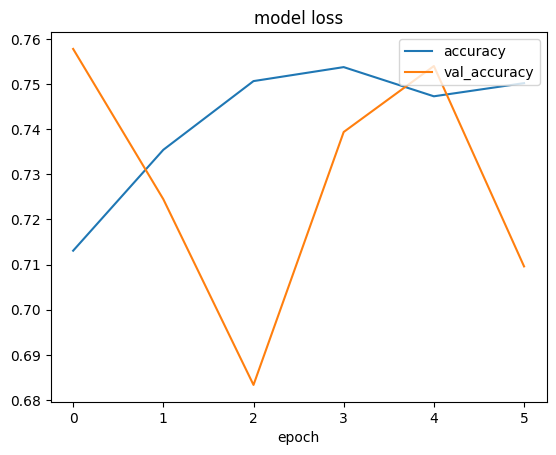

In [137]:
import matplotlib.pyplot as plt
plt.plot(m.history['accuracy'])
plt.plot(m.history['val_accuracy'])
plt.title('model loss')
# plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['accuracy','val_accuracy'], loc='upper right')
plt.show()

In [138]:
print("Inference:")
from keras.models import load_model
model = load_model("models/weights_best_t4.hdf5")

Inference:


In [139]:
# Plotting ROC curve to determine the threshold
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth=2, label = label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=11)
    plt.ylabel('True Positive Rate (Recall)', fontsize=11)
    plt.grid(True)

289/289 [==============================] - 2s 6ms/step
AUC = 0.8222


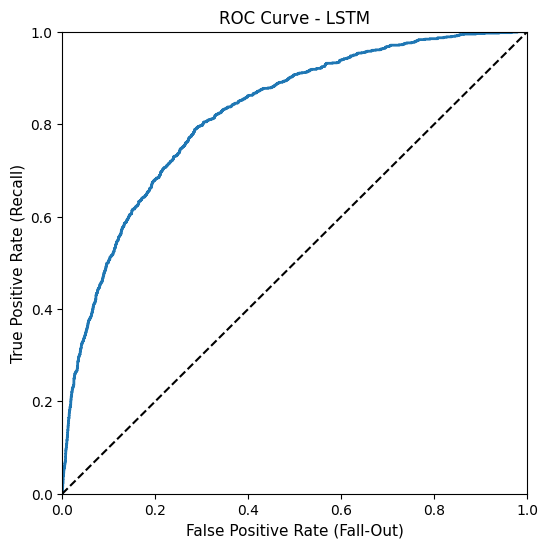

In [140]:
# Predict the test set using the best random forest regressor
y_pred = model.predict(x_test)

# Plotting ROC curve
fpr_rf_test, tpr_rf_test, thresholds_roc_rf_test = roc_curve(np.argmax(y_test, axis=1), y_pred[:, 1], pos_label=1)
# fpr_rf_test, tpr_rf_test, thresholds_roc_rf_test = roc_curve(y_test, y_pred, pos_label=1)
auc_t0_rf = auc(fpr_rf_test, tpr_rf_test)
print("AUC = {:.4f}".format(auc_t0_rf))

plt.figure(figsize=(6, 6))
plot_roc_curve(fpr_rf_test, tpr_rf_test)
plt.title("ROC Curve - LSTM")
plt.grid(False)
plt.show()

In [129]:
def print_results(M, X_train, Y_train, X_test, Y_test):
    # np.set_printoptions(suppress=True)
    # result1 = M.evaluate(X, Y, verbose = 2)
    # act_acc = np.round(result1[1]*100,2)
    # print("***[RESULT]*** ACT Accuracy: "+str(act_acc))
    Y_train = np.argmax(Y_train, axis=1)
    Y_test = np.argmax(Y_test, axis=1)

    preds_train = M.predict(X_train)
    preds_train = np.argmax(preds_train, axis=1)
    conf_mat_train = confusion_matrix(Y_train, preds_train)
    # conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

    preds_test = M.predict(X_test)
    preds_test = np.argmax(preds_test, axis=1)
    conf_mat_test = confusion_matrix(Y_test, preds_test)
    # conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

    print("***[RESULT]*** ACT  Confusion Matrix")
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

    x_labels = ["Predicted\nNon-Sepsis", "Predicted\nSepsis"]
    y_labels = ["Actual Non-Sepsis", "Actual Sepsis"]
    sns.heatmap(conf_mat_train, fmt='d', annot=True, xticklabels=x_labels, yticklabels=y_labels, ax=axes[0])
    sns.heatmap(conf_mat_test, fmt='d', annot=True, xticklabels=x_labels, yticklabels=y_labels, ax=axes[1])

    axes[0].set_title("CM in training set", fontsize = 10)
    axes[1].set_title("CM in test set", fontsize = 10)
    axes[0].tick_params(labelsize=9)
    axes[1].tick_params(labelsize=9)
    plt.tight_layout()
    plt.show()

    f1_train = f1_score(Y_train, preds_train)
    f1_test = f1_score(Y_test, preds_test)
    acc_train = balanced_accuracy_score(Y_train, preds_train)
    acc_test = balanced_accuracy_score(Y_test, preds_test)
    # Computing precision and recall
    precision_train = precision_score(Y_train, preds_train)
    precision_test = precision_score(Y_test, preds_test)
    recall_train = recall_score(Y_train, preds_train)
    recall_test = recall_score(Y_test, preds_test)
    # table = pd.DataFrame({'F1-Score':[f1_train, f1_test], 'Balanced Acc':[acc_train, acc_test],
    #                      'Precision':[precision_train, precision_test], 'Recall':[recall_train, recall_test]},
    #                      index=['Train', 'Test'])

    table = pd.DataFrame({'Train':[acc_train, precision_train, recall_train, f1_train], 'Test':[acc_test, precision_test, recall_test, f1_test]},
                         index=['Balanced Acc', 'Precision', 'Recall', 'F1-Score'])
    print(table)

289/289 [==============================] - 2s 5ms/step
***[RESULT]*** ACT  Confusion Matrix


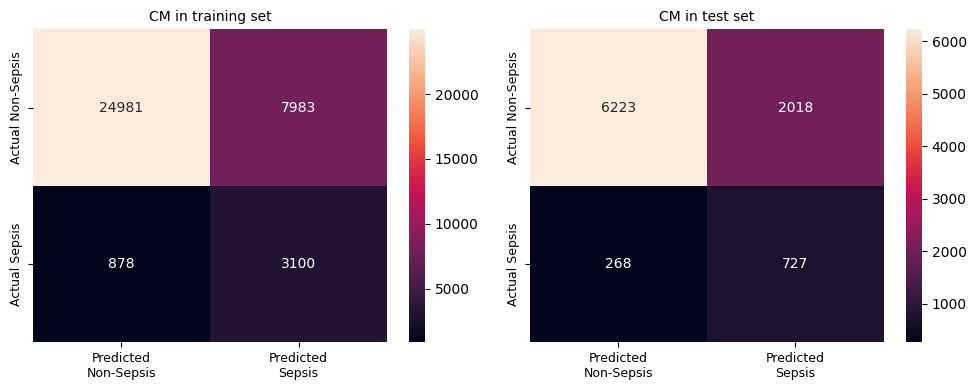

                 Train      Test
Balanced Acc  0.768556  0.742890
Precision     0.279708  0.264845
Recall        0.779286  0.730653
F1-Score      0.411659  0.388770


In [141]:
print_results(model, x_train, y_train, x_test, y_test)

# TimeSHAP

Model entry point

In [20]:
f = lambda x: model.predict(x)[:, 1]
raw_model_features = train_t0_df.columns
model_features = [f"p_normalize_{x}" for x in np.delete(raw_model_features, [0,1,4])]

In [21]:
d_train_normalized = pd.concat([train_t0_df, pd.DataFrame(X_t0_train, columns=model_features)], axis=1)
d_test_normalized = pd.concat([test_t0_df, pd.DataFrame(X_t0_test, columns=model_features)], axis=1)

Baseline event

In [22]:
from timeshap.utils import calc_avg_event
average_event = calc_avg_event(d_train_normalized, numerical_feats=model_features, categorical_feats=[])

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [42]:
average_event

,p_AGE_normalize,p_GENDER_NUM_normalize,p_ITEMID_50804_normalize,p_ITEMID_50813_normalize,p_ITEMID_50818_normalize,p_ITEMID_50820_normalize,p_ITEMID_50821_normalize,p_ITEMID_50862_normalize,p_ITEMID_50863_normalize,p_ITEMID_50878_normalize,...,p_ITEMID_51244_normalize,p_ITEMID_51248_normalize,p_ITEMID_51256_normalize,p_ITEMID_51265_normalize,p_ITEMID_51274_normalize,p_ITEMID_51275_normalize,p_ITEMID_51277_normalize,p_ITEMID_51279_normalize,p_ITEMID_51301_normalize,p_ITEMID_51493_normalize
0,0.187396,-0.850357,-0.842224,-0.848199,-0.842027,-0.890172,-0.832588,-0.501391,-0.611267,-0.482339,...,-0.913225,0.713598,-0.91318,0.562068,0.887343,0.898833,0.715028,0.715364,0.702611,-0.298054


In [ ]:
from timeshap.utils import calc_avg_sequence
average_sequence = calc_avg_sequence(d_train_normalized, numerical_feats=model_features, categorical_feats=[],model_features=model_features, entity_col='HADM_ID')

Average score over baseline

In [23]:
print("Inference:")
from keras.models import load_model
model = load_model("weights_best_t4.hdf5")

Inference:


In [44]:
model.predict(test_data).shape

289/289 [==============================] - 2s 5ms/step


(9233, 2)

In [ ]:
from timeshap.utils import get_avg_score_with_avg_event
avg_score_over_len = get_avg_score_with_avg_event(f, average_event, top=480)

## Local Explanations

In [133]:
ids_for_test = [183628, 116009, 107064, 109235] # first 2 hadm_id are sepsis case, last 2 are non-sepsis
pos_x_pd = d_test_normalized[d_test_normalized['HADM_ID'].isin(ids_for_test)]
labels = d_test_normalized[d_test_normalized.HADM_ID.isin(ids_for_test)].drop_duplicates(['HADM_ID'])[['HADM_ID', 'IS_SEPSIS']]

# select model features only
# pos_x_data = pos_x_pd[model_features]
# convert the instance to numpy so TimeSHAP receives it
pos_x_data = [np.expand_dims(pos_x_pd[pos_x_pd.HADM_ID==x][model_features].to_numpy().copy(), axis=0) for x in ids_for_test]

In [25]:
_, df_desc_labitems,_ = dataLoader.load_descriptions()

In [26]:
plot_feats_1 = {x:x[12:] for x in model_features[:2]}
plot_feats_2 = {x: df_desc_labitems[df_desc_labitems.ITEMID == int(x[19:])].LABEL.values[0] for x in model_features[2:]}
plot_feats = {**plot_feats_1, **plot_feats_2}

In [130]:
from timeshap.explainer import local_report, local_pruning, local_feat
from timeshap.plot import plot_feat_barplot, plot_global_feat, feature_level
import altair  as alt
sequence_id_feat = 'HADM_ID'

def plot_local_features(ids_for_test, pos_x_data, labels):
  objects = len(ids_for_test)
  plots = []
  for pos_id in list(range(0,objects)):
    hadm_id = ids_for_test[pos_id]
    pos_x = pos_x_data[pos_id]
    label = 'SEPSIS' if labels[labels.HADM_ID == hadm_id]['IS_SEPSIS'].values==1 else 'NON-SEPSIS'
    pruning_dict = {'tol': 0.025,}
    coal_plot_data, coal_prun_idx = local_pruning(f, pos_x, pruning_dict, average_event, hadm_id, sequence_id_feat, False)
    # coal_prun_idx is in negative terms
    pruning_idx = pos_x.shape[1] + coal_prun_idx

    feature_dict = {'rs': 42, 'nsamples': 32000, 'feature_names': model_features, 'plot_features': plot_feats}
    feature_data = local_feat(f, pos_x, feature_dict, hadm_id, sequence_id_feat, average_event, pruning_idx)
    feat_plot_0 = plot_feat_barplot(feature_data, feature_dict.get('top_feats'), feature_dict.get('plot_features'))
    feat_plot_0 = feat_plot_0.properties(width=500, height = {'step': 15}, title=f'HADM_ID: {hadm_id}, {label}')
    feat_plot_0 = feat_plot_0.encode(
        x=alt.X('Shapley Value', type='quantitative', scale=alt.Scale(domain=[-0.5, 0.5]))
    )
    plots.append(feat_plot_0)
  return plots

In [134]:
feat_plots = plot_local_features(ids_for_test, pos_x_data, labels)

1000/1000 [==============================] - 2s 2ms/step


In [135]:
(feat_plots[0] | feat_plots[1]) & (feat_plots[2] | feat_plots[3])

alt.VConcatChart(...)

## Global Explanation

In [75]:
d_test_normalized['timestamp'] = d_test_normalized.groupby(['SUBJECT_ID', 'HADM_ID']).cumcount()
d_test_normalized.timestamp = d_test_normalized.timestamp.astype(int)

In [143]:
from timeshap.explainer import prune_all, pruning_statistics, event_explain_all, feat_explain_all
from timeshap.plot import plot_global_event, plot_global_feat

pos_dataset = d_test_normalized
schema = list(pos_dataset.columns)
time_feat = 'timestamp'

In [ ]:
pruning_dict = {'tol': [0.05, 0.075], 'path': 'outputs/prun_all_tf.csv'}
prun_indexes = prune_all(f, pos_dataset, pruning_dict, average_event, model_features, schema, sequence_id_feat, time_feat)
# pruning_stats = pruning_statistics(prun_indexes, pruning_dict.get('tol'))
# pruning_stats

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 26s 26s/step


In [78]:
# prun_indexes = pd.read_csv('prun_all_tf.csv')
prun_indexes

In [1]:
event_dict = {'rs': 42, 'nsamples': 32000}
event_data = event_explain_all(f, pos_dataset, event_dict, prun_indexes, average_event, model_features, schema, sequence_id_feat, time_feat)
event_global_plot = plot_global_event(event_data)
event_global_plot

NameError: ignored